In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
from statistics import mode

import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics

In [2]:
# set asthetics 
sns.set()

In [3]:
# load data
df = pd.read_csv('ANZ_transaction_final.csv')

### Target - Annual Salary

In [4]:
df['date'] = pd.to_datetime(df['date'], format='%Y/%m/%d')

In [5]:
# create a list of customers
list_customer = df['customer_id'].unique()

In [6]:
df_sal = df[df['txn_description']=='PAY/SALARY']

In [7]:
# example (for the calculation below)
temp = df_sal.loc[df_sal['customer_id']=='CUS-497688347', ['date', 'amount']].groupby('date', as_index=False).sum()
temp['freq'] = temp['date'].diff().dt.days
temp

,date,amount,freq
0,2018-08-23,4910.9,NaN
1,2018-10-23,4910.9,61.0


In [8]:
max(temp['freq'].mode())

61.0

In [9]:
# calculate annual salary payment frequency and amount (for each payment) 
freq_mode = []
amount_mode = []

for customer in list_customer:
    sal_per_customer = df_sal.loc[df_sal['customer_id']==customer, ['date', 'amount']].groupby('date', as_index=False).sum()
    sal_per_customer['freq'] = sal_per_customer['date'].diff().dt.days
    freq_mode.append(max(sal_per_customer['freq'].mode()))  # we use max(.mode()) here to account for the situatio where there are multiple modes
    amount_mode.append(mode(sal_per_customer['amount']))

In [10]:
df_sal_freq = pd.DataFrame({'customer_id':list_customer, 'freq_mode':freq_mode, 'amount_mode':amount_mode})

In [11]:
# calculate annual salary
df_sal_freq['salary'] = df_sal_freq['amount_mode']/df_sal_freq['freq_mode']*365.25 

In [12]:
df_sal_freq.head(2)

,customer_id,freq_mode,amount_mode,salary
0,CUS-2487424745,7.0,1013.67,52891.852500
1,CUS-2142601169,7.0,1002.13,52289.711786


In [13]:
df_sal_freq['freq_mode'].value_counts()

14.0    51
7.0     40
31.0     5
30.0     2
61.0     1
32.0     1
Name: freq_mode, dtype: int64

Text(0.5, 1.0, 'Customer Annual Salary Distribution')

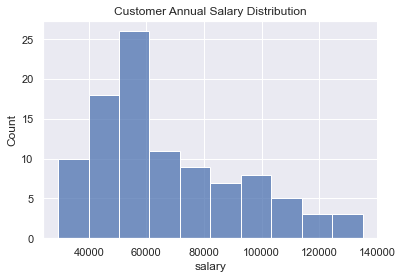

In [14]:
# create a histgram of salary
sns.histplot(x=df_sal_freq['salary'], bins=10)
plt.title('Customer Annual Salary Distribution')

### Features

Demographic features:
- age
- gender
- state

Generated features related to consumption behaviour:
- average volume of transactions per week (vol_weekly_trans)
- volume of large transactions (vol_large_trans)
- median purchasing amount (pur_med)
- max purchasing amount
- average purchasing amount (pur_mean)
- median balance (bal_med)
- median purchase distance (dist_med)

#### Feature Engineering

##### vol_weekly_trans, vol_large_trans, pur_med, pur_mean, pur_max

In [15]:
# purchase transaction df 
df_pur = df[(df['txn_description']=='POS')|(df['txn_description']=='SALES-POS')]

In [16]:
# create fearures related to purchase behaviour
df_pur_mean = df_pur.assign(large_trans=np.where(df_pur['amount']>100, df_pur['transaction_id'], np.NaN)) \
                    .groupby(['customer_id', 'age'], as_index=False) \
                    .agg(vol_weekly_trans=('date', lambda x: 7*len(x)/x.nunique()),
                         vol_large_trans=('large_trans', 'count'), 
                         pur_med=('amount', 'median'),
                         pur_max=('amount', 'max'), 
                         pur_mean=('amount', 'mean'))
                         
                    
df_pur_mean.head()

,customer_id,age,vol_weekly_trans,vol_large_trans,pur_med,pur_max,pur_mean
0,CUS-1005756958,53,13.440000,4,23.285,226.82,37.726250
1,CUS-1117979751,21,11.741935,1,17.895,2885.85,76.458077
2,CUS-1140341822,28,13.787879,5,20.180,1271.46,67.531385
3,CUS-1147642491,34,13.641026,5,36.640,432.92,51.128289
4,CUS-1196156254,34,17.553846,6,20.960,390.67,30.310491


> This shows a possible relationship between age and salary: positive correlation when age is below 40 and negative when it goes above. Therefore, we go back and create a dummy variable to represent it.

##### age dummy

<AxesSubplot:xlabel='age', ylabel='salary'>

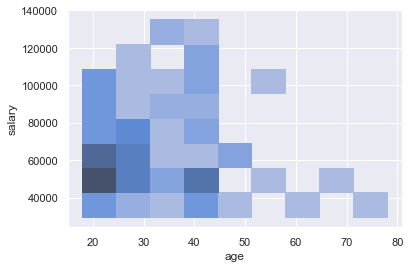

In [17]:
sns.histplot(data=df_sal_freq.merge(df_pur_mean, on='customer_id'), x='age', y='salary')

In [18]:
df['age_below_40'] = df['age'].apply(lambda x: 1 if x<=40 else 0)
df['age_above_40'] = df['age'].apply(lambda x: 1 if x>40 else 0)

##### dist_med, gender dummy, state dummy

In [19]:
df_temp = df.groupby(['customer_id', 'gender', 'age_below_40', 'age_above_40'], as_index=False) \
            .agg(dist_med=('dist', 'median'), 
                 state=('merchant_state', lambda x: x.value_counts().index[0]),  # assume the most appeared mechant_state is where th customer lives 
                 bal_med=('balance', 'median'))                                                                              

In [20]:
df_temp.head()

,customer_id,gender,age_below_40,age_above_40,dist_med,state,bal_med
0,CUS-1005756958,F,0,1,23.436556,QLD,1204.40
1,CUS-1117979751,M,1,0,25.263214,WA,8838.41
2,CUS-1140341822,M,1,0,46.680844,VIC,6358.35
3,CUS-1147642491,F,1,0,19.944993,NSW,8473.43
4,CUS-1196156254,F,1,0,871.360981,SA,22312.76


In [21]:
# one-hot encoding for categorical variables
df_temp = pd.get_dummies(df_temp, columns=['gender', 'state'])

#### Put it all together

In [22]:
# combine target and all the features 
df_customer = df_sal_freq[['customer_id', 'salary']].merge(df_pur_mean, on='customer_id', how='left').merge(df_temp, on='customer_id', how='left')

In [23]:
df_customer.head()

,customer_id,salary,age,vol_weekly_trans,vol_large_trans,pur_med,pur_max,pur_mean,age_below_40,age_above_40,dist_med,bal_med,gender_F,gender_M,state_NSW,state_NT,state_QLD,state_SA,state_VIC,state_WA
0,CUS-2487424745,52891.852500,26,45.329268,4,10.700,1452.21,18.491921,1,0,14.743016,1580.40,1,0,0,0,1,0,0,0
1,CUS-2142601169,52289.711786,38,27.600000,7,14.215,2349.55,35.093333,1,0,23.124223,1132.66,0,1,1,0,0,0,0,0
2,CUS-1614226872,46547.981786,40,24.838710,9,22.000,235.36,31.114864,1,0,26.084318,3618.50,1,0,0,0,1,0,0,0
3,CUS-2688605418,60534.969643,20,14.140000,9,21.620,444.28,40.687525,1,0,16.942323,5616.63,0,1,1,0,0,0,0,0
4,CUS-4123612273,55728.801429,43,29.750000,9,24.860,760.27,58.124235,0,1,16.350294,6162.45,1,0,0,0,0,0,1,0


In [24]:
df_customer.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100 entries, 0 to 99
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       100 non-null    object 
 1   salary            100 non-null    float64
 2   age               100 non-null    int64  
 3   vol_weekly_trans  100 non-null    float64
 4   vol_large_trans   100 non-null    int64  
 5   pur_med           100 non-null    float64
 6   pur_max           100 non-null    float64
 7   pur_mean          100 non-null    float64
 8   age_below_40      100 non-null    int64  
 9   age_above_40      100 non-null    int64  
 10  dist_med          100 non-null    float64
 11  bal_med           100 non-null    float64
 12  gender_F          100 non-null    uint8  
 13  gender_M          100 non-null    uint8  
 14  state_NSW         100 non-null    uint8  
 15  state_NT          100 non-null    uint8  
 16  state_QLD         100 non-null    uint8  
 17

In [25]:
df_customer.describe()

,salary,age,vol_weekly_trans,vol_large_trans,pur_med,pur_max,pur_mean,age_below_40,age_above_40,dist_med,bal_med,gender_F,gender_M,state_NSW,state_NT,state_QLD,state_SA,state_VIC,state_WA
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,67103.639579,31.770000,14.442699,3.860000,25.071850,754.094200,48.797409,0.800000,0.200000,383.051287,17615.427500,0.440000,0.560000,0.290000,0.020000,0.100000,0.070000,0.390000,0.130000
std,25079.318644,11.544254,5.284075,2.930233,9.942594,1027.711536,33.723821,0.402015,0.402015,1236.073434,35407.246539,0.498888,0.498888,0.456048,0.140705,0.301511,0.256432,0.490207,0.337998
min,29405.020082,18.000000,7.000000,0.000000,10.700000,17.950000,12.625000,0.000000,0.000000,8.022262,1132.660000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,48074.987679,22.000000,11.184091,2.000000,17.685000,204.187500,30.572128,1.000000,0.000000,18.982986,4640.597500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,59861.735625,29.500000,13.579134,3.000000,23.395000,398.025000,38.292905,1.000000,0.000000,25.996355,7361.767500,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,83591.962902,39.250000,15.812500,5.000000,28.593750,945.702500,55.486615,1.000000,0.000000,111.448800,12843.655000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,135038.664643,78.000000,45.329268,15.000000,59.010000,7081.090000,241.917778,1.000000,1.000000,10814.305954,264103.820000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [48]:
# sns.pairplot(df_customer.iloc[1:])

<AxesSubplot:>

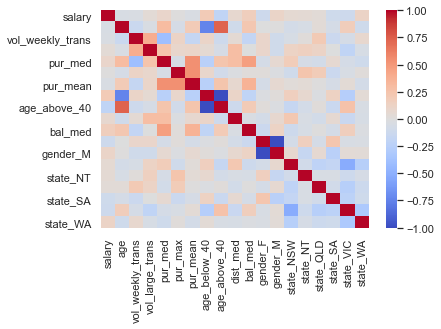

In [27]:
sns.heatmap(df_customer.iloc[1:].corr(), cmap='coolwarm')

### Modelling

#### Linear regression with full data and backward selection

In [28]:
col = df_customer.columns.to_list()

In [29]:
X = df_customer[col[2:]]
y = df_customer[col[1]]

In [62]:
# by backward selection, we eliminate features of which p-value are more than 0.05
X_back = X.drop(['age', 'vol_large_trans', 'vol_weekly_trans', 'pur_med', 'pur_max', 'pur_mean', 'state_NSW', 'state_NT', 'state_QLD', 'state_SA', 'state_VIC', 'state_WA', 'dist_med'], axis=1)
x = sm.add_constant(X_back) 
results = sm.OLS(y,x).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 salary   R-squared:                       0.091
Model:                            OLS   Adj. R-squared:                  0.062
Method:                 Least Squares   F-statistic:                     3.184
Date:                Thu, 09 Sep 2021   Prob (F-statistic):             0.0273
Time:                        11:12:56   Log-Likelihood:                -1149.6
No. Observations:                 100   AIC:                             2307.
Df Residuals:                      96   BIC:                             2318.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         2.996e+04   1717.307     17.443      0.000    2.65e+04    3.34e+04
age_below_40  2.225e+04   2662.551      8.356      0.000     1.7e+04    2.75e+04
age_above_40  7706.0639   3687.003      2.090      0.039     387.420     1.5e+04
bal_med          0.1459      0.071      2.054      0.043       0.005       0.287
gender_F      1.281e+04   2627.907      4.875      0.000    7595.808     1.8e+04
gender_M      1.714e+04   2604.360      6.582      0.000     1.2e+04    2.23e+04
==============================================================================
Omnibus:                       13.811   Durbin-Watson:                   1.855
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               15.082
Skew:                           0.921   Prob(JB):                     0.000531
Kurtosis:                       3.473   Cond. No.                     2.51e+20
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.47e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

#### Linear regression with training data and predictions

In [41]:
# divide date to training and testing data with 20% being testing data
X_train, X_test, y_train, y_test = train_test_split(X_back, y, test_size=0.3, random_state=42)

In [42]:
lm = LinearRegression()

In [43]:
lm.fit(X_train,y_train)

LinearRegression()

In [56]:
# coefficient
pd.DataFrame(lm.coef_, X_back.columns, columns=['coefficient'])

,coefficient
age_below_40,11599.298515
age_above_40,-11599.298515
bal_med,0.123550
gender_F,-1562.502865
gender_M,1562.502865


In [57]:
# intercept
lm.intercept_

59007.40406846208

In [45]:
predictions = lm.predict(X_test)

#### Model evaluation

In [46]:
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

RMSE: 25580.855681178728


> The RMSE is large and the ajusted R-squared suggest that only 6.2% of the target is explained. This is inevitable as the sample size is only 100. We need more data to develop a better performing model.